## Custom Classes and Functions

### Trade class 

In [1]:
class Trade:
    def __init__(self, ticker, price, count, holding_until, long):
        self.ticker = ticker
        self.price = price
        self.holding_until = holding_until
        self.long = long
        self.count = count
        self.profit = 0
    
    def is_due(self, date):
        if date >= self.holding_until:
            return True
        else:
            return False
        
    def close(self, current_price):
        dif = 0
        if self.long:
            dif = current_price - self.price
        else:
            dif = self.price - current_price
        
        self.profit = dif*self.count
        return self.profit
        
    
    def __str__(self):
        return f"{self.ticker} at {self.price} holding until {str(self.holding_until)}"

### Simple backtester

In [30]:
from datetime import date, timedelta
import math

def pair_backtesting(cash, df, step_func):
    profit_series = [cash]
    cash_on_hand = [cash]
    open_trades = []
    closed_trades = []
        
    counter = 0
    for index, row in df.iterrows():
        counter += 1
        current_profit = profit_series[len(profit_series)-1]
        current_cash =  cash_on_hand[len(cash_on_hand)-1]
        
        for trade in open_trades:
            if trade.is_due(index):
                trade.close(row[trade.ticker])
                current_profit += trade.profit
                current_cash = current_cash + int(math.sqrt(trade.profit**2))
                open_trades.remove(trade)
                closed_trades.append(trade)

        trades = step_func(df.iloc[0:counter])
        for trade in trades:
            cost = trade.price * trade.count
            current_cash = current_cash - cost
            open_trades.append(trade)

        profit_series.append(current_profit)
        cash_on_hand.append(current_cash)

    return profit_series, cash_on_hand, closed_trades

### Z-Score Pair Spread Strategy

In [31]:
def zscore_pair_spread(df):
    
    threshold = 1.0
    holding_time = timedelta(days=15)
    multiplier = 1

    
    if df.shape[0] > 0:
        spread = df[df.columns[0]] - df[df.columns[1]]
        ratios_mavg5 = spread.rolling(window=5, center=False).mean()
        ratios_mavg20 = spread.rolling(window=20, center=False).mean()
        std_20 = spread.rolling(window=20, center=False).std()
        zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
        current_z_score = zscore_20_5.tail(1)[0]
        
        last = df.iloc[-1]
        # Index hier irgendwie abrufen und dann unten bei holding_until einfügen
        last_date = datetime.strptime(str(last.name), '%Y-%m-%d %H:%M:%S')
        
        ratio = last[df.columns[0]] / last[df.columns[1]]
        
        if current_z_score < -threshold:        
            trades = []
            trades.append(Trade(ticker=df.columns[0], price=last[df.columns[0]], count=multiplier, holding_until=last_date+holding_time, long=True))
            trades.append(Trade(ticker=df.columns[1], price=last[df.columns[1]], count=multiplier*ratio, holding_until=last_date+holding_time, long=False))
            return trades
        elif current_z_score > threshold:
            trades = []
            trades.append(Trade(ticker=df.columns[0], price=last[df.columns[0]], count=multiplier, holding_until=last_date+holding_time, long=False))
            trades.append(Trade(ticker=df.columns[1], price=last[df.columns[1]], count=multiplier*ratio, holding_until=last_date+holding_time, long=True))
            return trades
        else:
            return []
        
    else:
        return []

### Z-Score Pair Ratio Strategy

In [41]:
def zscore_pair_ratio(df):
    
    threshold = 1.25
    holding_time = timedelta(days=15)
    multiplier = 1

    
    if df.shape[0] > 0:
        spread = df[df.columns[0]] / df[df.columns[1]]
        ratios_mavg5 = spread.rolling(window=5, center=False).mean()
        ratios_mavg20 = spread.rolling(window=20, center=False).mean()
        std_20 = spread.rolling(window=20, center=False).std()
        zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
        current_z_score = zscore_20_5.tail(1)[0]
        
        last = df.iloc[-1]
        # Index hier irgendwie abrufen und dann unten bei holding_until einfügen
        last_date = datetime.strptime(str(last.name), '%Y-%m-%d %H:%M:%S')
        
        ratio = last[df.columns[0]] / last[df.columns[1]]
        
        if current_z_score < -threshold:        
            trades = []
            trades.append(Trade(ticker=df.columns[0], price=last[df.columns[0]], count=multiplier, holding_until=last_date+holding_time, long=True))
            trades.append(Trade(ticker=df.columns[1], price=last[df.columns[1]], count=multiplier*ratio, holding_until=last_date+holding_time, long=False))
            return trades
        elif current_z_score > threshold:
            trades = []
            trades.append(Trade(ticker=df.columns[0], price=last[df.columns[0]], count=multiplier, holding_until=last_date+holding_time, long=False))
            trades.append(Trade(ticker=df.columns[1], price=last[df.columns[1]], count=multiplier*ratio, holding_until=last_date+holding_time, long=True))
            return trades
        else:
            return []
        
    else:
        return []

In [33]:
from statsmodels.tsa.stattools import adfuller
def adfuller_tests(stock1, stock2):
    Spread_ADF = adfuller(stock1-stock2)[1]
    Ratio_ADF = adfuller(stock1/stock2)[1]
    
    return Spread_ADF, Ratio_ADF

## Get Data

In [34]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

def get_historical_Data(tickers, start_date, end_date):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data,pdr.get_data_yahoo(symbols=i, start=start_date, end=end_date).iloc[:,5]], axis = 1)
        names.append(i)
    data.columns = names
    return data

# Insert your custom tickers here:
ticks = ["MRVL", "ADI", "AVGO", "INTC", "TSM", "MCHP", "TXN", "NVDA", "LRCX", "KLAC"] 

d_train = get_historical_Data(ticks, datetime(2018, 1, 1), datetime(2021, 1, 1))
d_test = get_historical_Data(ticks, datetime(2021, 1, 1), datetime(2021, 10, 23))

d = d_train.append(d_test)

print(d_train.shape)
# Most Recent Data
d_train.tail()

(756, 10)


,MRVL,ADI,AVGO,INTC,TSM,MCHP,TXN,NVDA,LRCX,KLAC
2020-12-24 00:00:00,46.900013,142.645386,421.697937,46.199398,104.738602,67.816071,158.897644,129.840012,477.047455,256.767151
2020-12-28 00:00:00,46.830235,142.852707,422.108429,46.199398,104.916504,67.558220,158.730515,128.903198,472.836548,255.280548
2020-12-29 00:00:00,46.082626,141.845596,419.332703,48.476486,104.333359,67.017761,158.445435,129.335373,469.976288,252.089310
2020-12-30 00:00:00,47.348579,144.333771,424.991669,47.848328,107.634552,67.825981,159.939651,131.358871,481.129303,257.827606
2020-12-31 00:00:00,47.388454,145.864197,427.943329,48.898537,107.772919,68.480492,161.345398,130.452057,469.032776,256.598663


Found stationary pair in ADI and TXN with correlation 0.9810574379340552
Cointegration P-Value: (-3.6508168914055883, 0.021168779313590038, array([-3.90789658, -3.34250874, -3.04887548]))
AdFuller Spread P-Value: 0.25986277233166266
AdFuller Ratio P-Value 0.029775725118743875


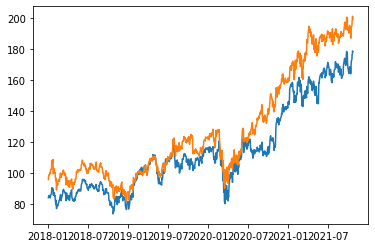

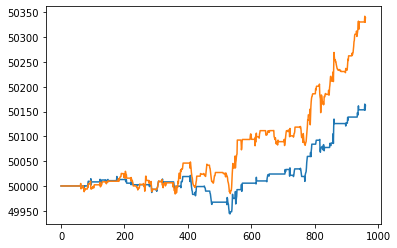

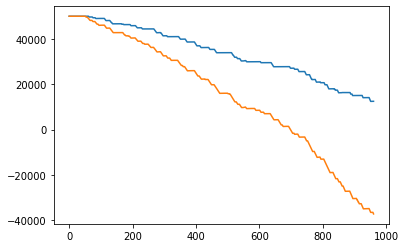

In [42]:
import statsmodels.tsa.stattools as ts 
import matplotlib.pyplot as plt 

corr_matrix = d.corr()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# Calculate correlations, take the best 10 and run cointegration and Augmented Dickey Fuller tests on them
# If ADFuller returns lower than 0,05 then run simple backtest on the strategy
for idx, row in get_top_abs_correlations(d, 10).iteritems():
    stock1 = idx[0]
    stock2 = idx[1]
    
    if stock1 and stock2:
        cointegration_res = ts.coint(d[stock1], d[stock2])
        adfuller_spread_res, adfuller_ratio_res = adfuller_tests(d[stock1], d[stock2])
                
        if adfuller_spread_res < 0.05 or adfuller_ratio_res < 0.05:
            print(f"Found stationary pair in {stock1} and {stock2} with correlation {row}")
            print(f"Cointegration P-Value: {cointegration_res}")
            print(f"AdFuller Spread P-Value: {adfuller_spread_res}")
            print(f"AdFuller Ratio P-Value {adfuller_ratio_res}")      
      
            plt.plot(d[stock1], label=stock1)
            plt.plot(d[stock2], label=stock2)
            plt.show()
            
            profit_ratio, cash_ratio, _ = pair_backtesting(50000, d[[stock1, stock2]], zscore_pair_ratio)
            profit_spread, cash_spread, _ = pair_backtesting(50000, d[[stock1, stock2]], zscore_pair_spread)

            plt.plot(profit_ratio, label="Profit Ratio")
            plt.plot(profit_spread, label="Cash Spread")
            plt.show()  
                
            plt.plot(cash_ratio, label="Cash Ratio")
            plt.plot(cash_spread, label="Cash Spread")
            plt.show()